In [691]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series, DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [692]:
tf.reset_default_graph()
data = pd.read_csv('TSE(original).csv',usecols=[4])
data.head(10)

,Close
0,7468.22
1,7361.94
2,7391.15
3,7371.44
4,7397.06
5,7450.53
6,7451.35
7,7367.44
8,7326.72
9,7424.91


In [693]:
n=data.shape[0]
p=data.shape[1]
print(n,p)
data=data.values
data

1341 1


array([[  7468.22],
       [  7361.94],
       [  7391.15],
       ..., 
       [ 11076.78],
       [ 11103.79],
       [ 11160.25]])

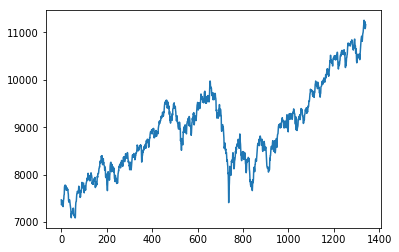

In [694]:
%matplotlib inline
plt.plot(data)
plt.show()

In [695]:
def create_dataset(dataset, look_back=1):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back+1):
        dataX.append(dataset[i:(i+look_back),0])
        dataY.append(dataset[i+look_back-1,0])

    return np.array(dataX), np.array(dataY)

In [696]:
#data normalization
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

# split into train and test sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size

print(train_size)
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(train.shape, test.shape)

look_back=8
x_train, y_train_o = create_dataset(train, look_back)
x_test,y_test_o= create_dataset(test, look_back)

print(x_train.shape,y_train_o.shape)
print(x_test.shape,y_test_o.shape)


1072
(1072, 1) (269, 1)
(1065, 8) (1065,)
(262, 8) (262,)


In [697]:
#define [0,1][1,0]
def create_updown(dataset):
    dataY=[]
    for i in range (len(dataset)-1):
        x= dataset[i+1]-dataset[i]
        if np.any(x>0):
            dataY.append([0,1])
        else:
            dataY.append([1,0])
    return np.array(dataY,dtype='float32')

In [698]:
y_train=create_updown(y_train_o)
if y_train_o[len(y_train_o)-1] > y_test_o[0]:
    y_train=np.vstack((y_train,[1,0]))
else:
    y_train=np.vstack((y_train,[0,1]))
print(y_train)
print(y_train.shape)
y_test=create_updown(y_test_o)
y_test=np.vstack((y_test,[1,0]))
print(y_test.shape)

[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]]
(1065, 2)
(262, 2)


In [699]:
def layer(output_dim,input_dim,inputs,activation):
    w=tf.Variable(tf.random_normal([input_dim,output_dim]))
    b=tf.Variable(tf.random_normal([1,output_dim]))
    xwb=tf.matmul(inputs,w)+b
    if activation is None:
        outputs=xwb
    else:
        outputs=activation(xwb)
    return outputs

In [700]:
x=tf.placeholder("float",[None,look_back])
h1=layer(output_dim=80, input_dim=look_back, inputs=x, activation=tf.nn.relu)
h2=layer(output_dim=30, input_dim=80, inputs=h1,activation=tf.nn.relu)
y_predict=layer(output_dim=2, input_dim=30, inputs=h2, activation=None)

In [701]:
y_label=tf.placeholder("float",[None,2])
loss_fun=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label))
optimizer=tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_fun)


In [702]:
correct_predict=tf.equal(tf.argmax(y_label,1),tf.argmax(y_predict,1))
accuracy= tf.reduce_mean(tf.cast(correct_predict,"float"))

In [703]:
trainEpochs=500
batchsize=100
loss_train=[];epoch_list=[];accuracy_train=[]
loss_test=[]; accuracy_test=[]
totalbatchs= int(len(data)//batchsize)
from time import time
startTime=time()

sess=tf.Session()
sess.run(tf.global_variables_initializer())

In [704]:

for epoch in range(trainEpochs):
    shuffle = np.random.permutation(len(y_train))
    x_train = x_train[shuffle]
    y_train = y_train[shuffle]
    for i in range(totalbatchs):
        sess.run(optimizer,feed_dict={x:x_train,y_label:y_train}) 
    
    loss_tra,acc_tra= sess.run([loss_fun, accuracy],feed_dict={x:x_train,y_label:y_train})
    loss_t,acc_t= sess.run([loss_fun, accuracy],feed_dict={x:x_test,y_label:y_test})

    epoch_list.append(epoch);
    loss_test.append(loss_t)
    loss_train.append(loss_tra)
    accuracy_test.append(acc_t)
    accuracy_train.append(acc_tra)
    #print ("Train Epoch:",'%02d'%(epoch+1),"Loss=","{:.9f}".format(loss),"Accuracy=",acc)

duration=time()-startTime

#pred_result = sess.run(tf.argmax(y_predict, 1), feed_dict={x: x_test})
#true_result = sess.run(tf.argmax(y_label, 1), feed_dict={y_label: y_test})

#print ('Pred Result=\n', pred_result)
#print ('True Result=\n', true_result)

print("Loss_train= ",loss_tra)
print ("Loss_test= ",loss_t)

print("Accuracy_train= ", acc_tra)
print("Accuracy_test= ", acc_t)

print("Train Finished takes:",duration)

Loss_train=  0.664243
Loss_test=  1.04914
Accuracy_train=  0.575587
Accuracy_test=  0.446565
Train Finished takes: 14.015199899673462


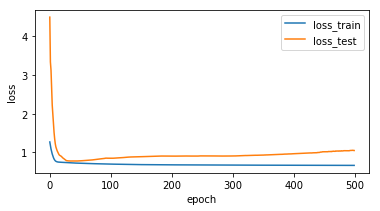

In [705]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.gcf()
fig.set_size_inches(6,3)
plt.plot(epoch_list,loss_train, label='loss_train')
plt.plot(epoch_list,loss_test, label='loss_test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

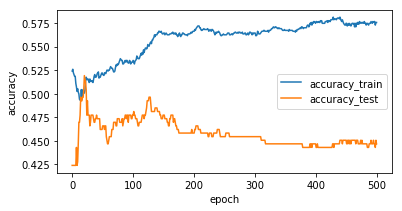

In [706]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.gcf()
fig.set_size_inches(6,3)
plt.plot(epoch_list,accuracy_train, label='accuracy_train')
plt.plot(epoch_list,accuracy_test, label='accuracy_test')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()